# Description

The notebook automates the process of pushing a pair of scenarios (baseline and alternative) through the simulation and optimization pipeline, comparing outputs for each scenario. Key outputs include harvested area (hectares), harvested volume (m³), and growth (m³). The notebook also reports stand age class distribution, old growth attributes, and tree species diversity at the beginning and end of the planning horizon for each scenario. Additionally, it calculates biodiversity and socioeconomic indicators, while quantifying differences between baseline and alternative scenarios in terms of carbon stocks and net emissions over a customizable simulation horizon, set to 100 years by default (the system can easily be parametrized to simulate shorter or longer horizons).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import libcbm
import os
from util import compile_events, cbm_report, compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, run_scenario, plugin_c_curves, plugin_c_curves, cbm_report_both, compare_ws3_cbm, compare_ws3_cbm_both, track_system_stock, track_system_emission, compile_scenario_minemission, plot_scenario_minemission, kpi_age, kpi_species, cmp_c_ss, cmp_c_se, results_scenarios, bootstrap_ogi, compare_kpi_age, epsilon_computer, tradeoff_biodiversity_cs, tradeoff_hv_cs, tradeoff_hv_biodiversity

In [3]:
# Initialize the input parameters
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'
max_harvest = 1.0

In [4]:
# Load the CSV file
file_path = "./data/AACs.csv"  # Update with your file path if needed
df = pd.read_csv(file_path)

# Convert to dictionary where TSA is the key and AAC is the value
aac_dict = dict(zip(df['TSA'], df['AAC']))

# Display the resulting dictionary
print(aac_dict)


{'tsa01': 500000, 'tsa02': 670142, 'tsa03': 840331, 'tsa04': 119791, 'tsa05': 808000, 'tsa07': 485000, 'tsa08': 2582350, 'tsa09': 424800, 'tsa10': 329024, 'tsa11': 2100000, 'tsa12': 1087000, 'tsa13': 550000, 'tsa14': 970000, 'tsa15': 375000, 'tsa16': 2321476, 'tsa17': 337574, 'tsa18': 1200000, 'tsa20': 1576043, 'tsa22': 2462800, 'tsa23': 967805, 'tsa24': 6935023, 'tsa25': 272061, 'tsa26': 2607000, 'tsa27': 225000, 'tsa29': 2937509, 'tsa30': 1220808, 'tsa31': 368276, 'tsa38': 315694, 'tsa39': 1050000, 'tsa40': 2115000, 'tsa41': 1791846, 'tsa43': 865000, 'tsa44': 845286, 'tsa45': 346920}


In [5]:
# Define scenario options based on case study


scenario_options = {

    'test': ['evenflow_cons', 'no_cons'],
    'ecotrust': ['lowest carbon stock', 'business as usual', '40% of highest carbon stock', '60% of highest carbon stock', '20% of highest carbon stock', 'highest carbon stock']
}
# scenario_options = {

#     'test': ['evenflow_cons'],
#     'ecotrust': ['business as usual', '40% of highest carbon stock']
# }
# Function to handle case study selection and update scenario dropdown
def select_case_study(case_study):
    print(f"Selected case study: {case_study}")
    # Update the scenario dropdown based on the selected case study
    scenario_dropdown.options = scenario_options.get(case_study, [])
    scenario_dropdown.value = scenario_options[case_study][0]  # Set a default value


case_study_dropdown = widgets.Dropdown(
    options=['test', 'ecotrust'],
    value='ecotrust',
    description='Case Study:'
)
case_study_dropdown.observe(lambda change: select_case_study(change['new']), names='value')
display(case_study_dropdown)

# Function to handle scenario selection
def select_scenario(scenario_name):
    print(f"Selected scenario: {scenario_name}")

# Scenario dropdown
scenario_dropdown = widgets.Dropdown(
    options=scenario_options['ecotrust'],  # Set initial options based on default case study
    value=scenario_options['ecotrust'][0],  # Set initial value
    description='Scenario:'
)
scenario_dropdown.observe(lambda change: select_scenario(change['new']), names='value')
display(scenario_dropdown)

# Function to handle objective functon
def select_obj(obj_mode):
    print(f"Selected objective: {obj_mode}")
obj_dropdown = widgets.Dropdown(
    options=['max_hv', 'min_ha', 'max_st', 'min_em'],
    value='max_hv',
    description='Objective:'
)
display(obj_dropdown)
obj_dropdown.observe(lambda change: select_obj(change['new']), names='value')

Dropdown(description='Case Study:', index=1, options=('test', 'ecotrust'), value='ecotrust')

Dropdown(description='Scenario:', options=('lowest carbon stock', 'business as usual', '40% of highest carbon …

Dropdown(description='Objective:', options=('max_hv', 'min_ha', 'max_st', 'min_em'), value='max_hv')

In [6]:
# Initialize main widget components 
hwp_pool_effect = widgets.FloatSlider(min=0, max=1, step=1, description='HWP_effect', value=0, layout=widgets.Layout(margin='10px 0'))
release_immediately = widgets.FloatSlider(min=0, max=1, step=1, description='Release immediately', value=0, layout=widgets.Layout(margin='10px 0'))
displacement_effect = widgets.FloatSlider(min=0, max=1, step=1, description='Displacement', value=1, layout=widgets.Layout(margin='10px 0'))
clt_percentage = widgets.FloatSlider(min=0, max=1, step=0.1, description='CLT_percent:', value=0.5, layout=widgets.Layout(margin='10px 0'))
credibility = widgets.FloatSlider(min=0, max=1, step=0.1, description='Credibility:', value=1, layout=widgets.Layout(margin='10px 0'))
# max_harvest = widgets.FloatSlider(min=0, max=1, step=0.05, description='Max_harvest:', value=1.0, layout=widgets.Layout(margin='10px 0'))
budget_input = widgets.FloatText(value=10000000, description='Budget:', layout=widgets.Layout(margin='10px 0'))

release_immediately.layout.display = 'none' if hwp_pool_effect.value != 0 else 'block'
displacement_effect.layout.display = 'block' if hwp_pool_effect.value != 0 else 'none'
clt_percentage.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'
credibility.layout.display = 'block' if hwp_pool_effect.value != 0 and displacement_effect.value != 0 else 'none'

container = widgets.VBox([
    hwp_pool_effect, release_immediately, displacement_effect, clt_percentage, credibility, budget_input  
    # ,max_harvest
])

display(container)

def update_widgets(change):
    hwp_pool_effect_value = hwp_pool_effect.value
    displacement_effect_value = displacement_effect.value

    release_immediately.layout.display = 'block' if hwp_pool_effect_value == 0 else 'none'
    displacement_effect.layout.display = 'block' if hwp_pool_effect_value != 0 else 'none'

    clt_percentage.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'
    credibility.layout.display = 'block' if hwp_pool_effect_value != 0 and displacement_effect_value != 0 else 'none'

hwp_pool_effect.observe(update_widgets, names='value')
displacement_effect.observe(update_widgets, names='value')

In [7]:
#Start Calculating the Running Time
Start = time.time()

In [8]:
case_study = case_study_dropdown.value
scenario_name = scenario_dropdown.value
obj_mode = obj_dropdown.value
hwp_pool_effect_value = hwp_pool_effect.value
release_immediately_value = release_immediately.value if hwp_pool_effect_value == 0 else 0
displacement_effect = displacement_effect.value if hwp_pool_effect_value != 0 else 0
clt_percentage = clt_percentage.value if displacement_effect != 0 else 0
credibility = credibility.value if displacement_effect != 0 else 0
# max_harvest = max_harvest.value
budget_input = budget_input.value

In [9]:
hwp_pool_effect_value

0.0

In [10]:
obj_mode

'max_hv'

In [11]:
# Define case study mappings and retrieve model details based on case study
case_study_options = {
    'test': {
        'model_name': 'ecotrust',
        'model_path': './data/woodstock_model_files_ecotrust'
    },
    'ecotrust': {
        'model_name': 'ecotrust',
        'model_path': './data/woodstock_model_files_ecotrust'
    }
}

model_info = case_study_options.get(case_study)

if model_info:
    model_name = model_info['model_name']
    model_path = model_info['model_path']
else:
    print('The case study name is not valid')


In [12]:
# Create and Run `ForestModel` instance
fm = ws3.forest.ForestModel(model_name=model_name,
                            model_path=model_path,
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [13]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [14]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping,
                                       include_empty_dtypes=True)

In [15]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [16]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                    
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [17]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

In [18]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
total_emission = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']
sum_fluxes = ['total_emission', 'gross_growth', 'net_emission']

In [19]:
# Read carbon curves
# file_directory = "./data/curves"
file_names = ["pi.csv", "fi.csv"]
# loaded_data = {}
file_path = ["./data/curves/pi.csv", "./data/curves/fi.csv"] 
pi = pd.read_csv(file_path[0], index_col=0)
fi = pd.read_csv(file_path[1], index_col=0)
# for filename in file_names:
#     file_path = os.path.join(file_directory, filename)
#     with open(file_path, 'rb') as file:
#         loaded_data[filename] = pickle.load(file)
#     print(f"Loaded data from {file_path}")

# c_curves_p = loaded_data.get(f"{case_study}_c_curves_p.pkl")
# c_curves_f = loaded_data.get(f"{case_study}_c_curves_f.pkl")

In [20]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[ecosystem_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [21]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [22]:
c_curves_f['total_emission'] = 44/12 * c_curves_f[total_emission].sum(axis=1)
c_curves_f['gross_growth'] = 44/12 * c_curves_f[gross_growth].sum(axis=1)
c_curves_f['net_emission'] = c_curves_f['total_emission'] - c_curves_f['gross_growth']

In [23]:
c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 0] = c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 1].values

In [24]:
# Plug carbon and old groth yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f)
bootstrap_ogi(fm)

Running for ecotrust_max_hv_lowest carbon stock...
running lowest carbon stock scenario


/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


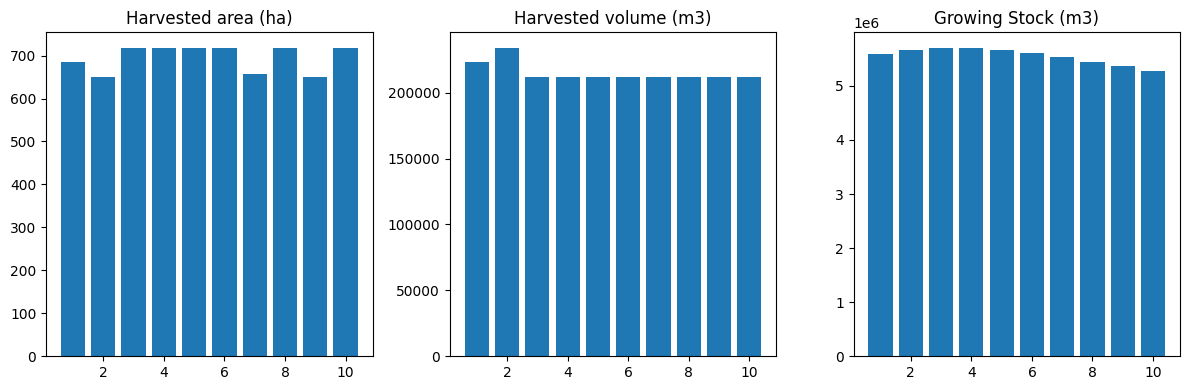

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_lowest carbon stock_scheduling.pdf


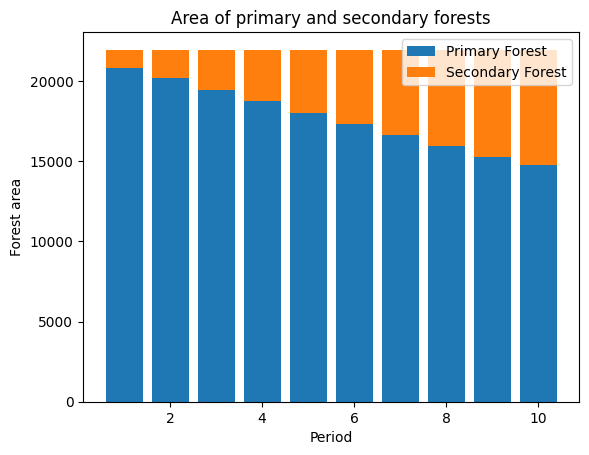

------------------------------------------------
The scocial indicator (the number of job creation) is:  2274
The economic indicator (the provincial government revenues) is:  77563
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_lowest carbon stock_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1469.850257  1186.273698
Aspen      42.290489   286.728098   244.437609
Spruce   4471.720232  3836.986311  -634.733921
Hem      1246.520025   826.921916  -419.598110
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  4484.193980   784.783142
DougFir   504.920628  1184.756286   679.835658
Pine      156.364968   156.393578     0.028610

Old growth has **increased** by 1864.03 hectares from time period 0 to ti

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


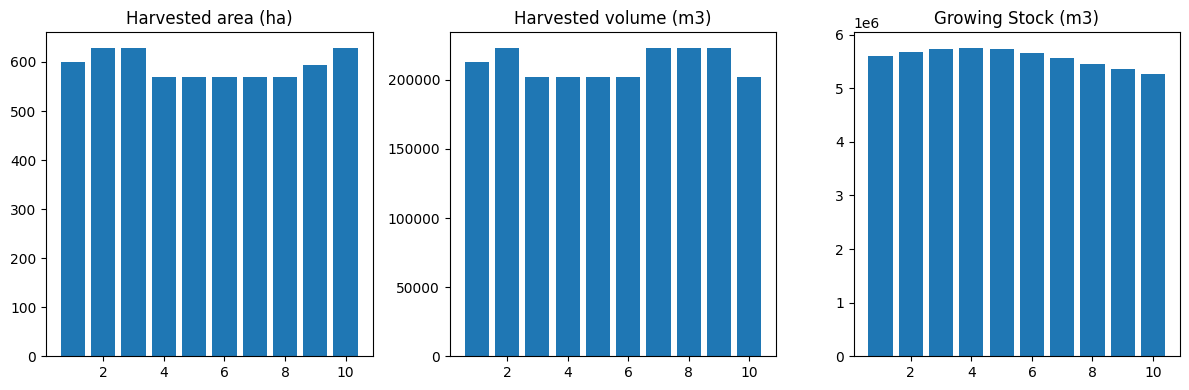

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


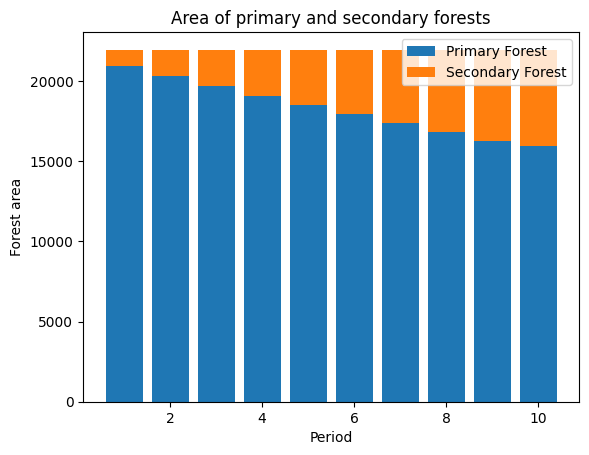

------------------------------------------------
The scocial indicator (the number of job creation) is:  2235
The economic indicator (the provincial government revenues) is:  76247
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1345.936035  1062.359477
Aspen      42.290489   199.632790   157.342301
Spruce   4471.720232  4804.661029   332.940797
Hem      1246.520025  1178.972393   -67.547633
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  5166.937298  1467.526460
DougFir   504.920628   881.080832   376.160204
Pine      156.364968   204.552976    48.188007

Old growth has **increased** by 3399.97 hectares from time period 0 to time

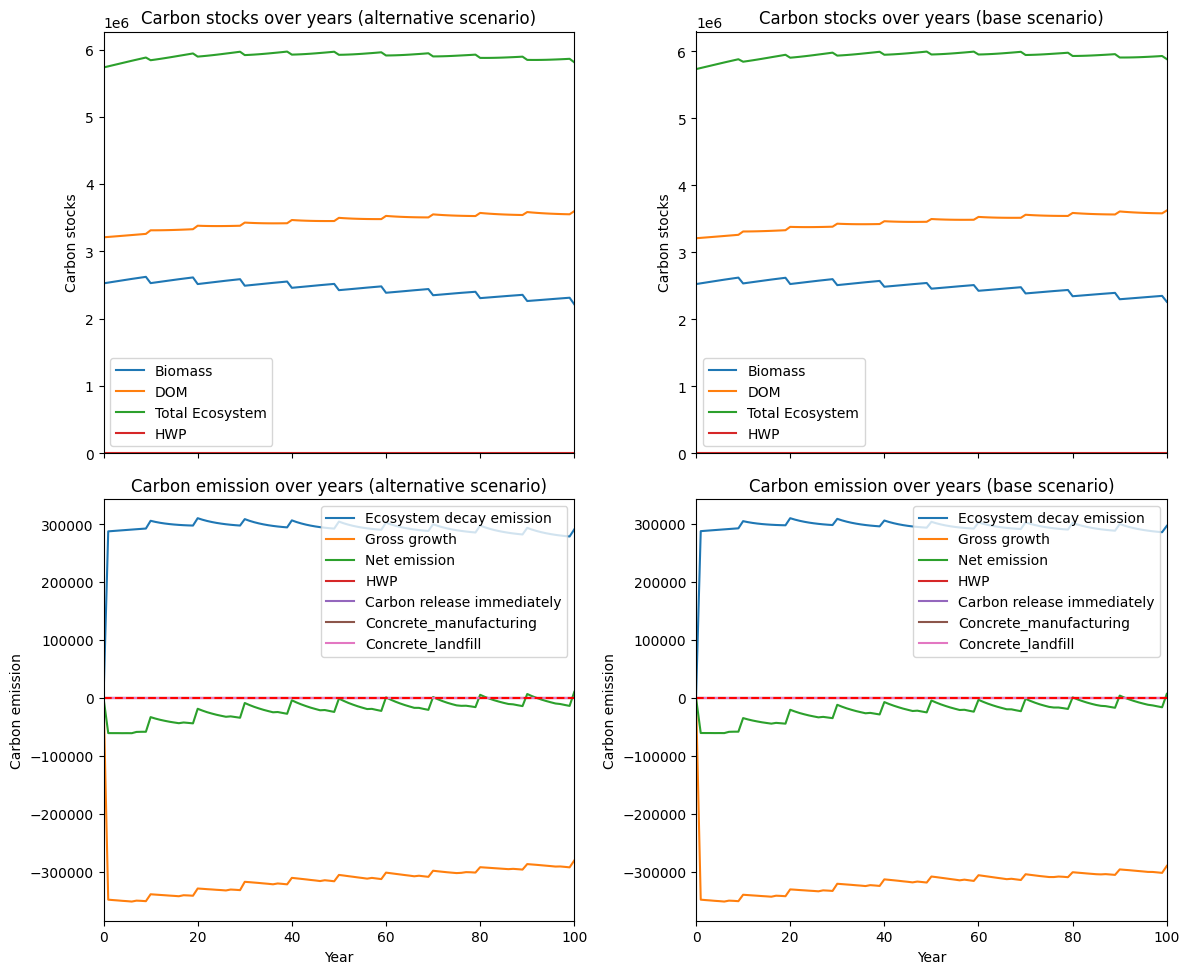

---------------------------------------------------------------------------------------
Net emission difference 220590.67145914293
Net emission base scenario -2265054.5554323117
Net emission alternative scenario -2044463.883973169
dollar_per_ton is:  45.33283267988133
Comparison of Old Growth Areas (Alternative - Base)
           0          10  Difference
Cedar    0.0  123.914222  123.914222
Aspen    0.0   87.095308   87.095308
Spruce   0.0 -967.674718 -967.674718
Hem      0.0 -352.050477 -352.050477
Birch    0.0    0.000000    0.000000
Bal      0.0 -682.743318 -682.743318
DougFir  0.0  303.675454  303.675454
Pine     0.0  -48.159397  -48.159397

Overall, the old growth area has **decreased** by -1535.94 hectares in the alternative scenario compared to the base scenario.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
--------------------------

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


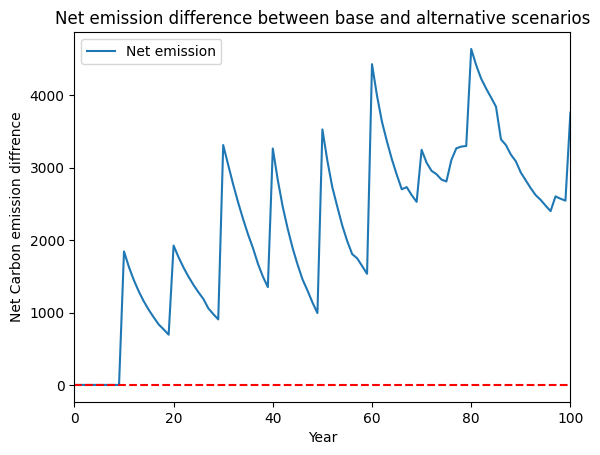

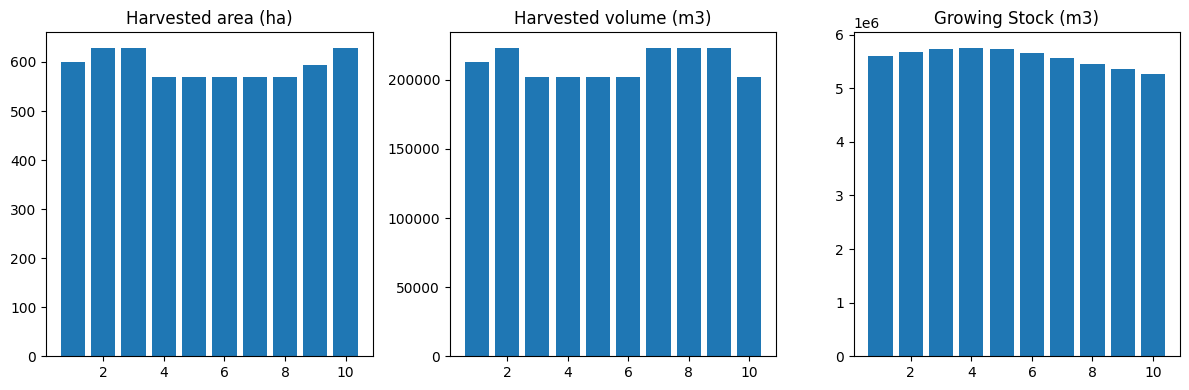

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


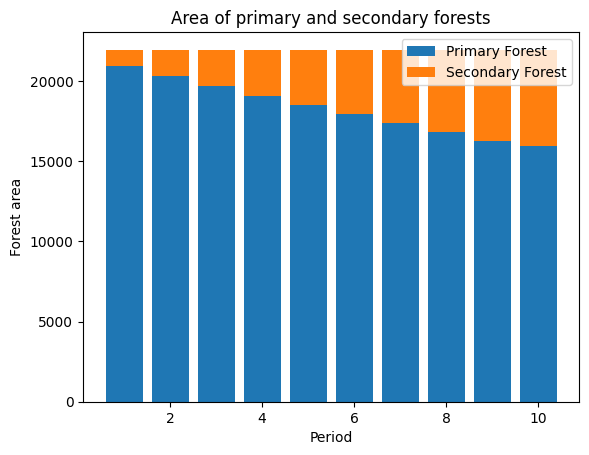

------------------------------------------------
The scocial indicator (the number of job creation) is:  2235
The economic indicator (the provincial government revenues) is:  76247
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1345.936035  1062.359477
Aspen      42.290489   199.632790   157.342301
Spruce   4471.720232  4804.661029   332.940797
Hem      1246.520025  1178.972393   -67.547633
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  5166.937298  1467.526460
DougFir   504.920628   881.080832   376.160204
Pine      156.364968   204.552976    48.188007

Old growth has **increased** by 3399.97 hectares from time period 0 to time

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


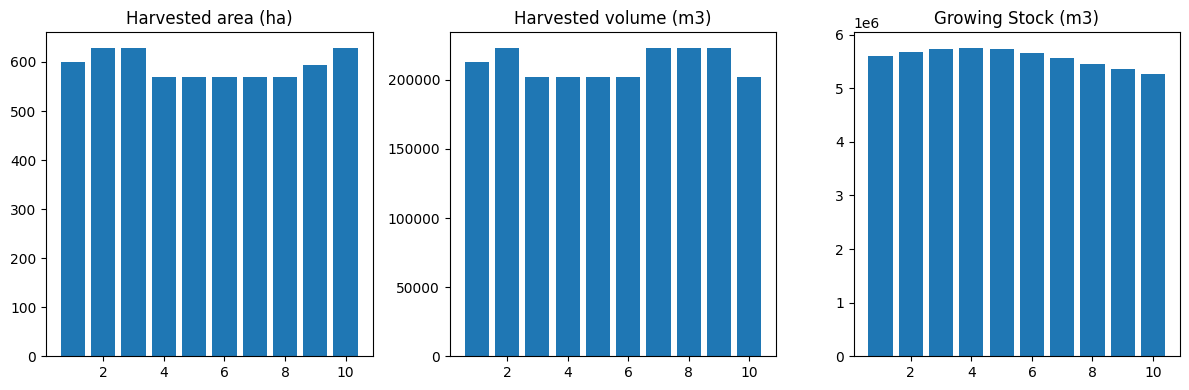

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


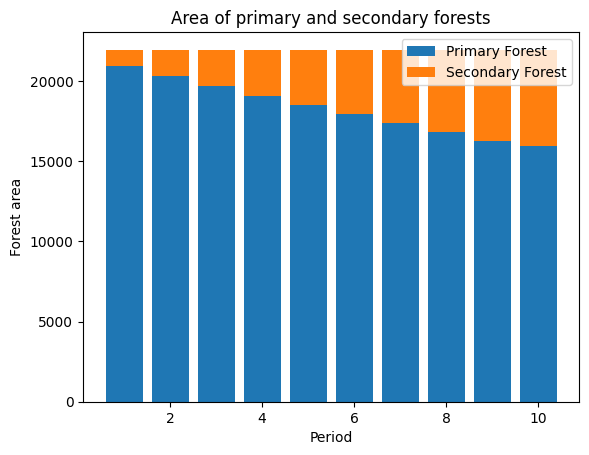

------------------------------------------------
The scocial indicator (the number of job creation) is:  2235
The economic indicator (the provincial government revenues) is:  76247
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1345.936035  1062.359477
Aspen      42.290489   199.632790   157.342301
Spruce   4471.720232  4804.661029   332.940797
Hem      1246.520025  1178.972393   -67.547633
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  5166.937298  1467.526460
DougFir   504.920628   881.080832   376.160204
Pine      156.364968   204.552976    48.188007

Old growth has **increased** by 3399.97 hectares from time period 0 to time

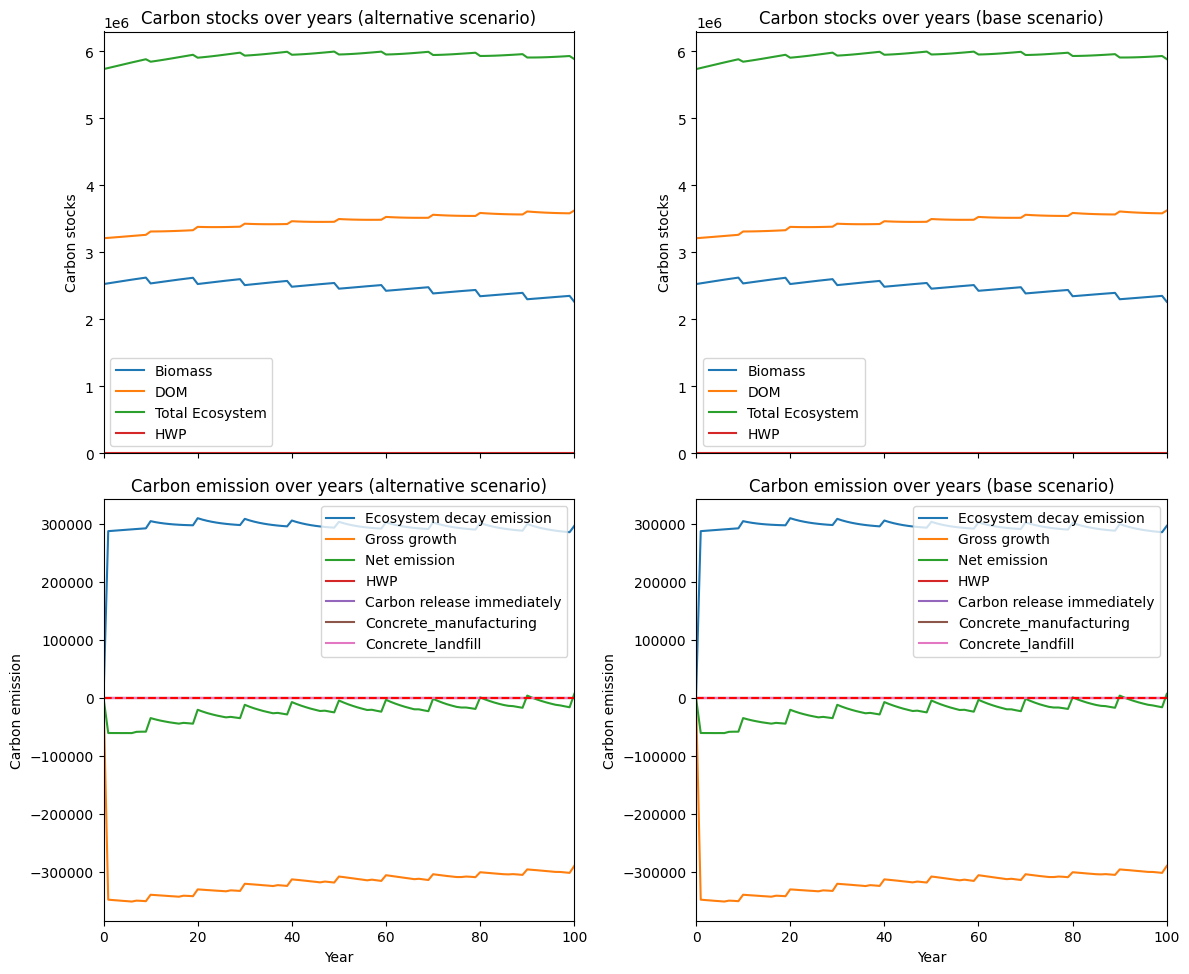

---------------------------------------------------------------------------------------
Net emission difference 0.0
Net emission base scenario -2265054.5554323117
Net emission alternative scenario -2265054.5554323117
dollar_per_ton is:  inf
Comparison of Old Growth Areas (Alternative - Base)
           0   10  Difference
Cedar    0.0  0.0         0.0
Aspen    0.0  0.0         0.0
Spruce   0.0  0.0         0.0
Hem      0.0  0.0         0.0
Birch    0.0  0.0         0.0
Bal      0.0  0.0         0.0
DougFir  0.0  0.0         0.0
Pine     0.0  0.0         0.0

Overall, the old growth area has **increased** by 0.00 hectares in the alternative scenario compared to the base scenario.


/media/data/project/sghotb/ecotrust-dss/util.py:1481: RuntimeWarning: divide by zero encountered in scalar divide
  dollar_per_ton = abs(budget_input / dif_scenario['Net emission'].sum()) # Calculate for the next 25 years


Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
---------------------------------------------------------------------------------------
Running for ecotrust_max_hv_40% of highest carbon stock...
running 40% of highest carbon stock scenario


/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


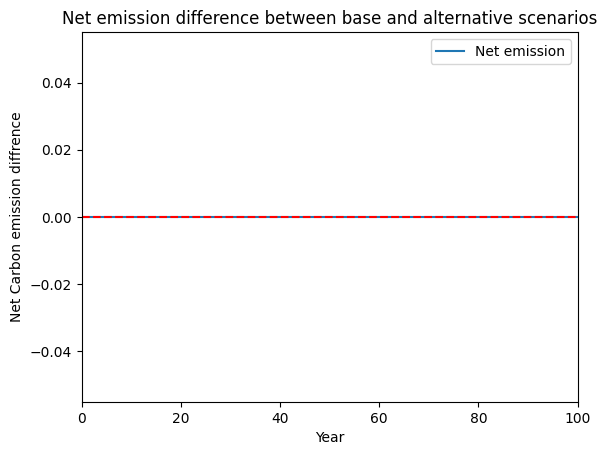

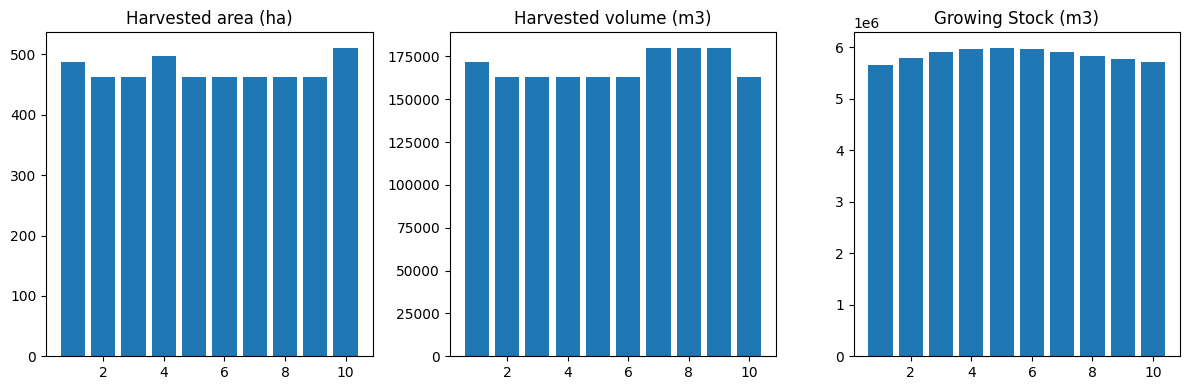

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_40% of highest carbon stock_scheduling.pdf


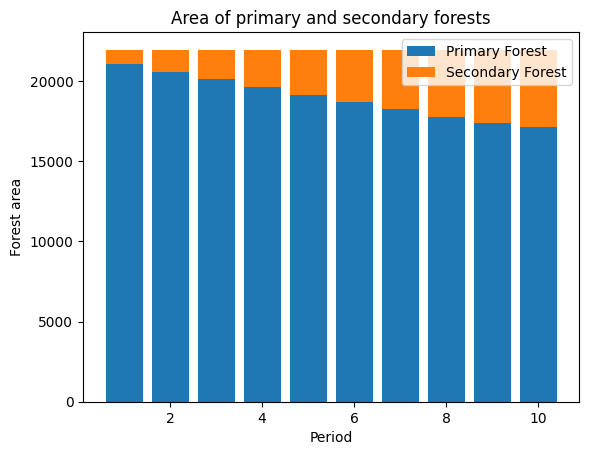

------------------------------------------------
The scocial indicator (the number of job creation) is:  1785
The economic indicator (the provincial government revenues) is:  60874
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_40% of highest carbon stock_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1506.424684  1222.848126
Aspen      42.290489   206.187584   163.897094
Spruce   4471.720232  5254.425701   782.705470
Hem      1246.520025  1541.217121   294.697096
Birch       3.090902    40.119295    37.028393
Bal      3699.410838  5278.623945  1579.213107
DougFir   504.920628   951.967410   447.046782
Pine      156.364968   204.552976    48.188007

Old growth has **increased** by 4575.62 hectares from time period

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


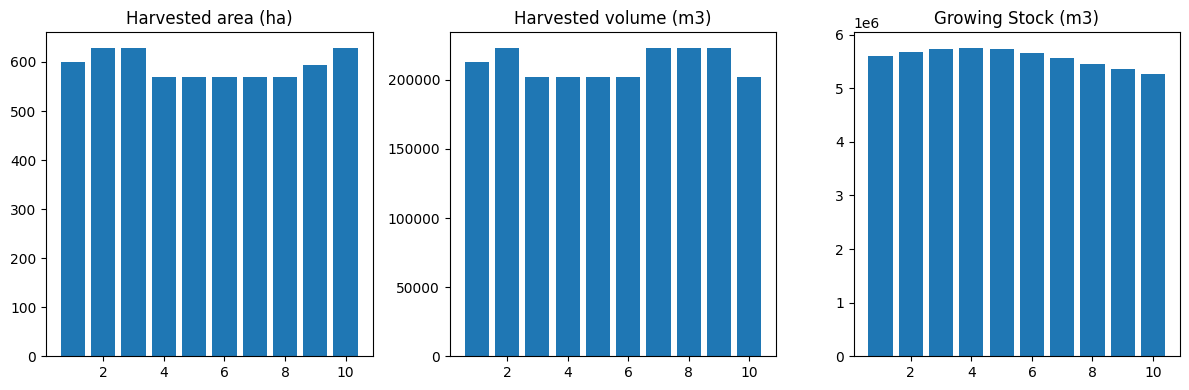

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


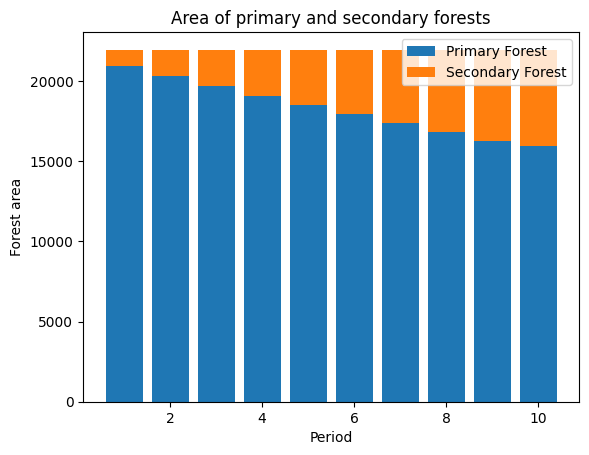

------------------------------------------------
The scocial indicator (the number of job creation) is:  2235
The economic indicator (the provincial government revenues) is:  76247
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1345.936035  1062.359477
Aspen      42.290489   199.632790   157.342301
Spruce   4471.720232  4804.661029   332.940797
Hem      1246.520025  1178.972393   -67.547633
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  5166.937298  1467.526460
DougFir   504.920628   881.080832   376.160204
Pine      156.364968   204.552976    48.188007

Old growth has **increased** by 3399.97 hectares from time period 0 to time

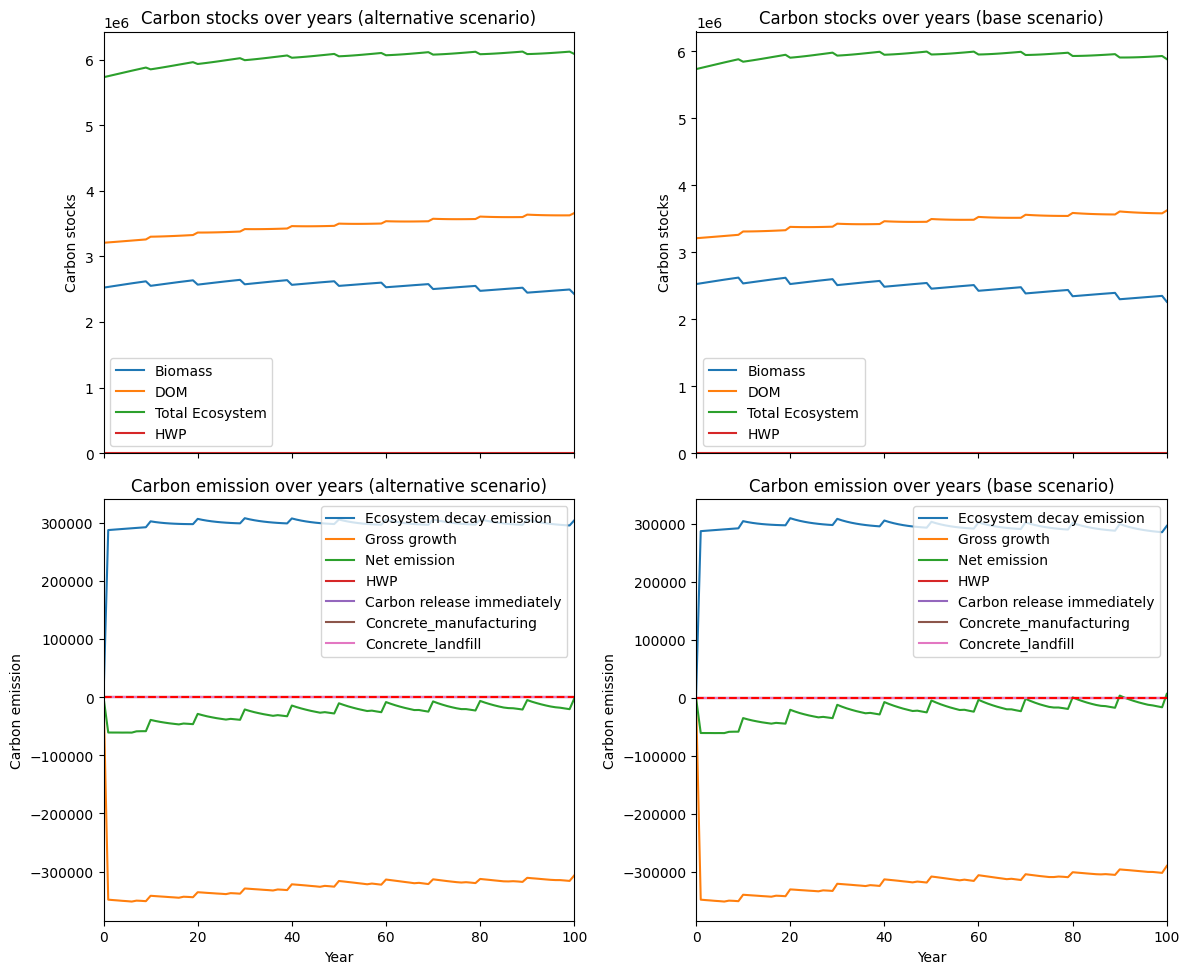

---------------------------------------------------------------------------------------
Net emission difference -423268.0235061929
Net emission base scenario -2265054.5554323117
Net emission alternative scenario -2688322.5789385047
dollar_per_ton is:  23.625692102048642
Comparison of Old Growth Areas (Alternative - Base)
           0          10  Difference
Cedar    0.0  160.488649  160.488649
Aspen    0.0    6.554794    6.554794
Spruce   0.0  449.764673  449.764673
Hem      0.0  362.244728  362.244728
Birch    0.0   14.026344   14.026344
Bal      0.0  111.686647  111.686647
DougFir  0.0   70.886578   70.886578
Pine     0.0    0.000000    0.000000

Overall, the old growth area has **increased** by 1175.65 hectares in the alternative scenario compared to the base scenario.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
-------------------------

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


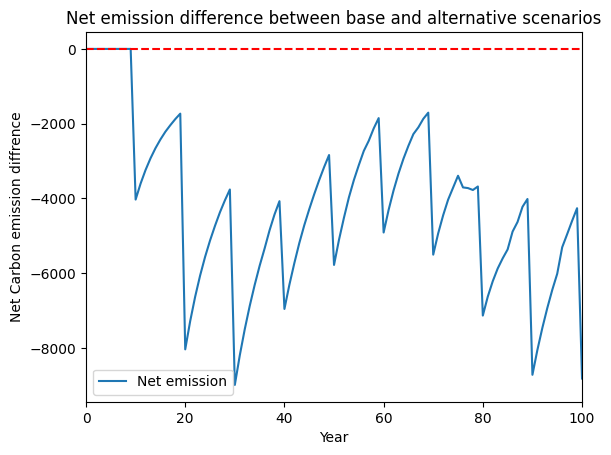

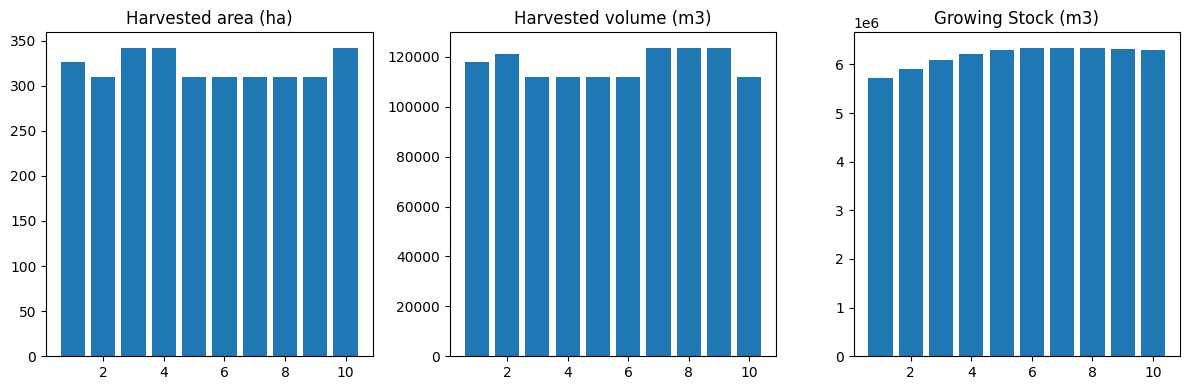

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_60% of highest carbon stock_scheduling.pdf


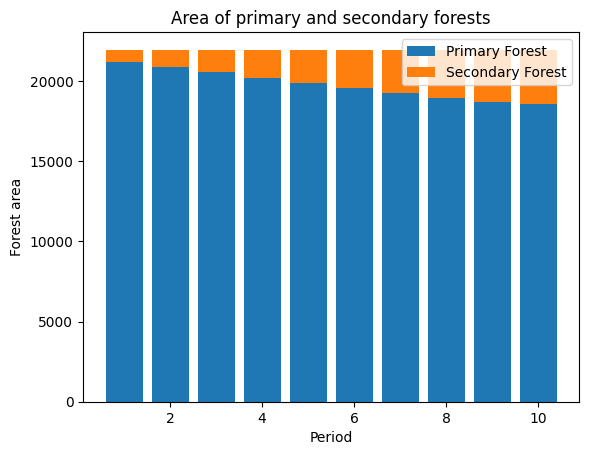

------------------------------------------------
The scocial indicator (the number of job creation) is:  1236
The economic indicator (the provincial government revenues) is:  42160
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_60% of highest carbon stock_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1656.666790  1373.090232
Aspen      42.290489   259.673913   217.383424
Spruce   4471.720232  6177.947497  1706.227265
Hem      1246.520025  1590.711518   344.191493
Birch       3.090902    40.119295    37.028393
Bal      3699.410838  5299.590315  1600.179477
DougFir   504.920628   991.125301   486.204674
Pine      156.364968   204.552976    48.188007

Old growth has **increased** by 5812.49 hectares from time period

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


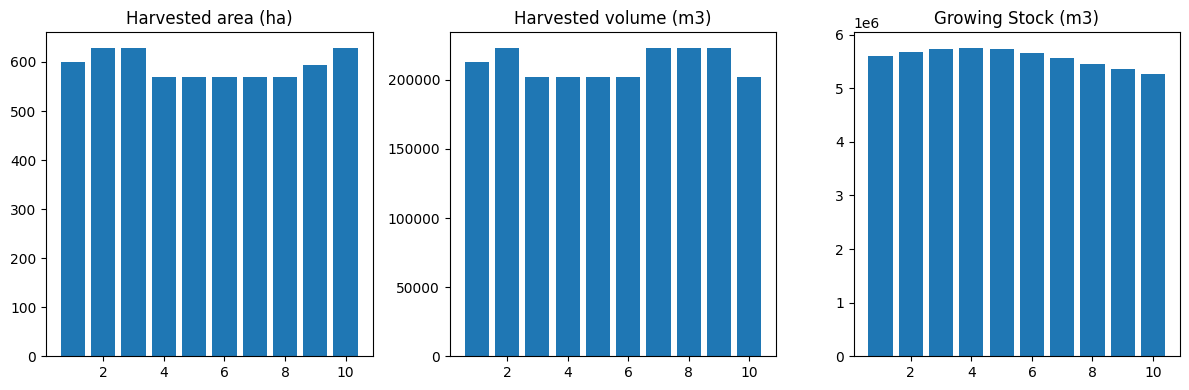

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


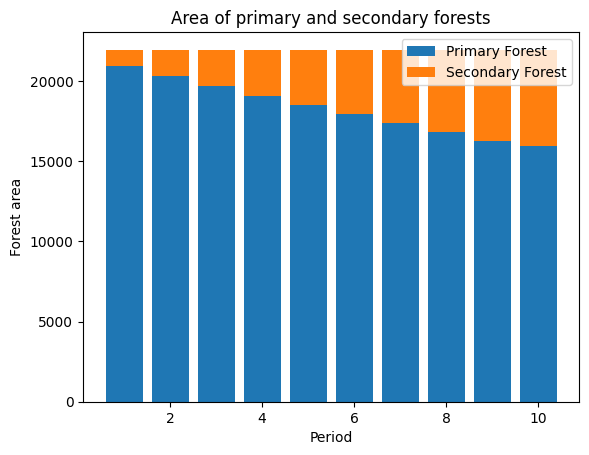

------------------------------------------------
The scocial indicator (the number of job creation) is:  2235
The economic indicator (the provincial government revenues) is:  76247
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1345.936035  1062.359477
Aspen      42.290489   199.632790   157.342301
Spruce   4471.720232  4804.661029   332.940797
Hem      1246.520025  1178.972393   -67.547633
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  5166.937298  1467.526460
DougFir   504.920628   881.080832   376.160204
Pine      156.364968   204.552976    48.188007

Old growth has **increased** by 3399.97 hectares from time period 0 to time

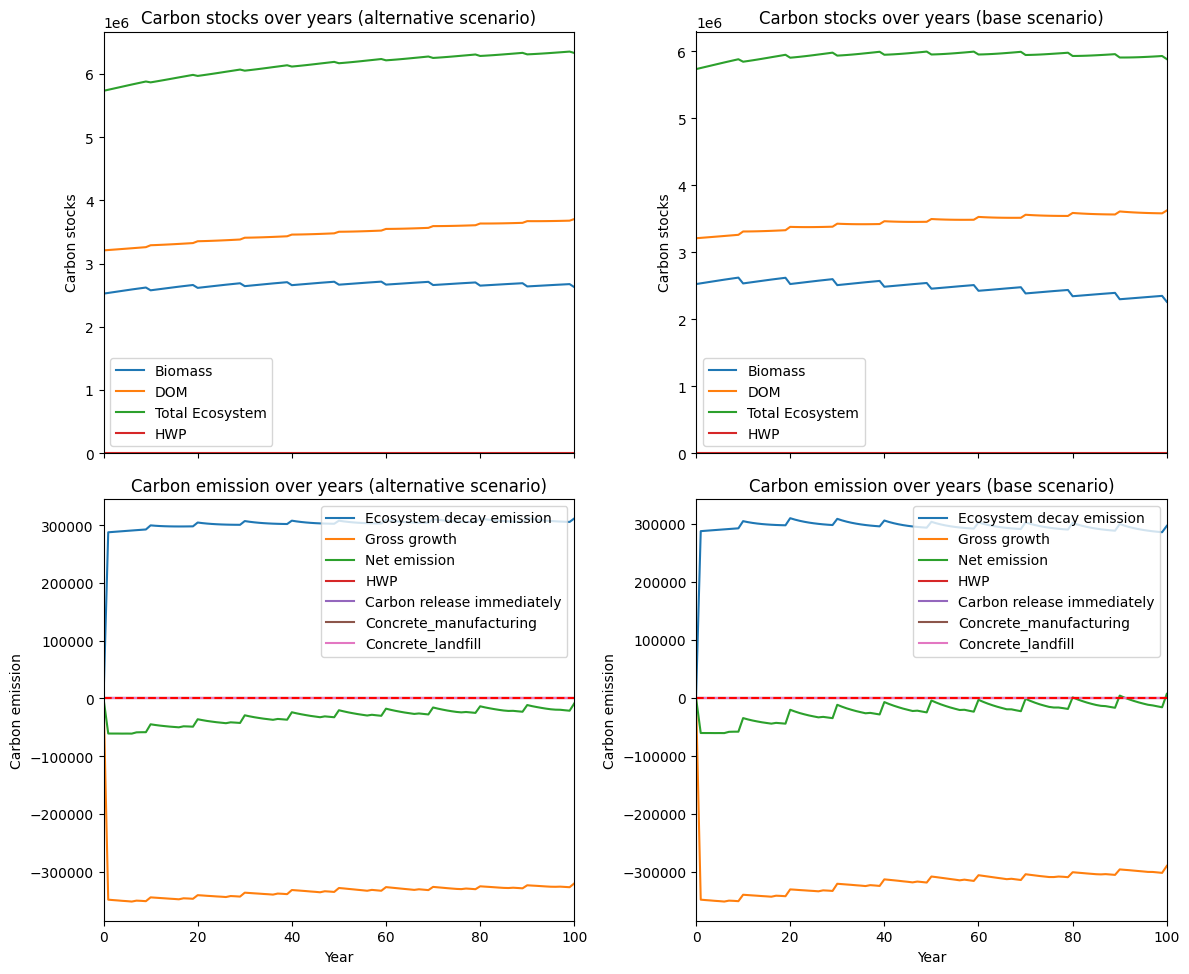

---------------------------------------------------------------------------------------
Net emission difference -892883.9073212991
Net emission base scenario -2265054.5554323117
Net emission alternative scenario -3157938.4627536107
dollar_per_ton is:  11.199664276625334
Comparison of Old Growth Areas (Alternative - Base)
           0           10   Difference
Cedar    0.0   310.730755   310.730755
Aspen    0.0    60.041123    60.041123
Spruce   0.0  1373.286468  1373.286468
Hem      0.0   411.739126   411.739126
Birch    0.0    14.026344    14.026344
Bal      0.0   132.653017   132.653017
DougFir  0.0   110.044470   110.044470
Pine     0.0     0.000000     0.000000

Overall, the old growth area has **increased** by 2412.52 hectares in the alternative scenario compared to the base scenario.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
-------

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


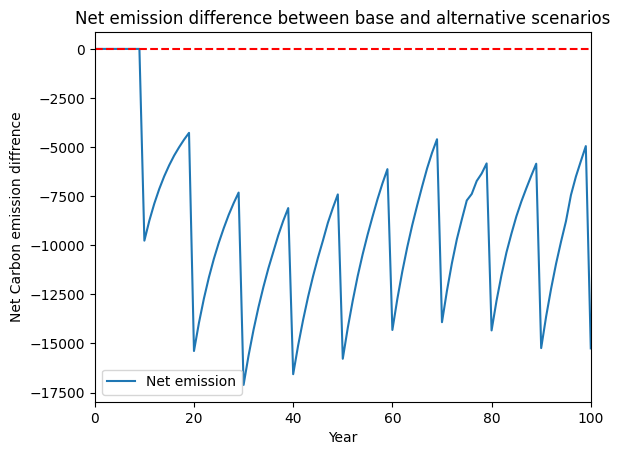

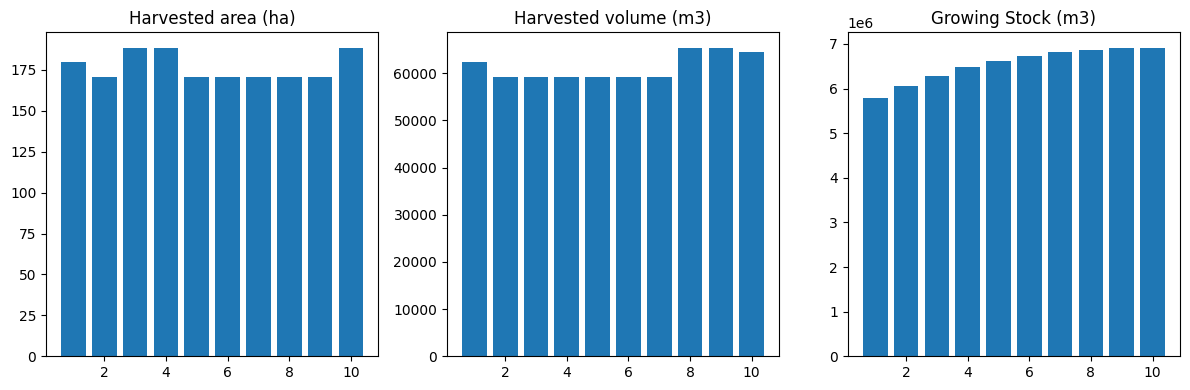

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_20% of highest carbon stock_scheduling.pdf


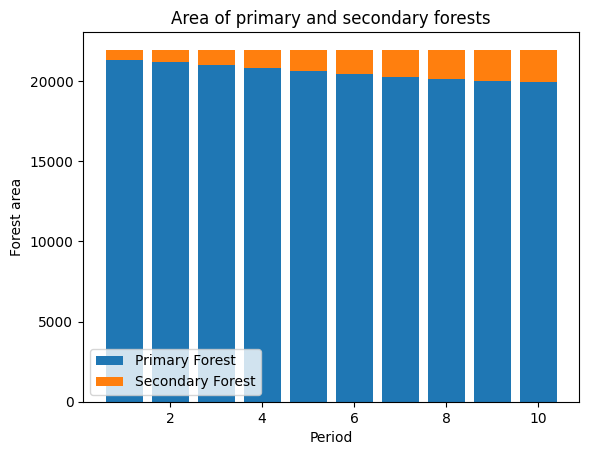

------------------------------------------------
The scocial indicator (the number of job creation) is:  647
The economic indicator (the provincial government revenues) is:  22090
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_20% of highest carbon stock_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1716.971259  1433.394700
Aspen      42.290489   300.204632   257.914142
Spruce   4471.720232  6735.026152  2263.305920
Hem      1246.520025  1590.711518   344.191493
Birch       3.090902    40.119295    37.028393
Bal      3699.410838  5331.685081  1632.274244
DougFir   504.920628  1479.643660   974.723033
Pine      156.364968   204.552976    48.188007

Old growth has **increased** by 6991.02 hectares from time period 

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


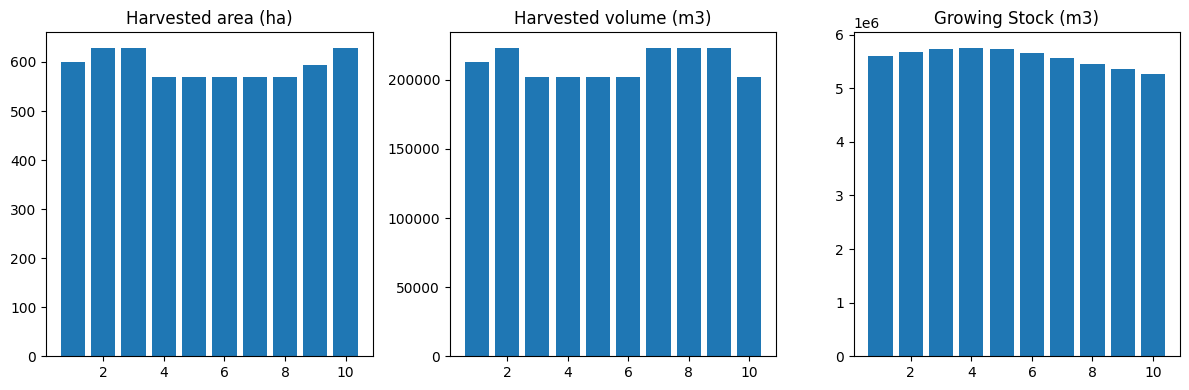

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


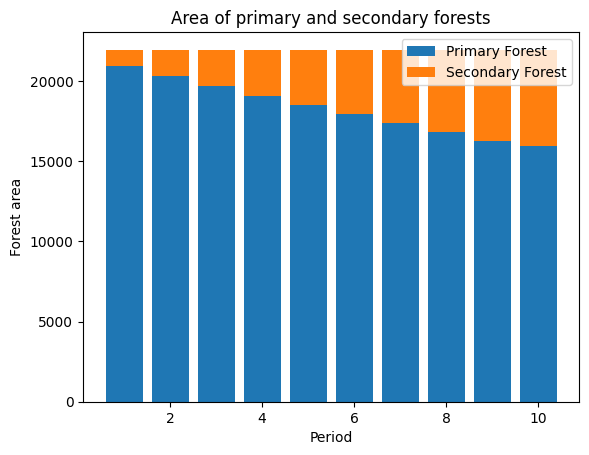

------------------------------------------------
The scocial indicator (the number of job creation) is:  2235
The economic indicator (the provincial government revenues) is:  76247
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1345.936035  1062.359477
Aspen      42.290489   199.632790   157.342301
Spruce   4471.720232  4804.661029   332.940797
Hem      1246.520025  1178.972393   -67.547633
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  5166.937298  1467.526460
DougFir   504.920628   881.080832   376.160204
Pine      156.364968   204.552976    48.188007

Old growth has **increased** by 3399.97 hectares from time period 0 to time

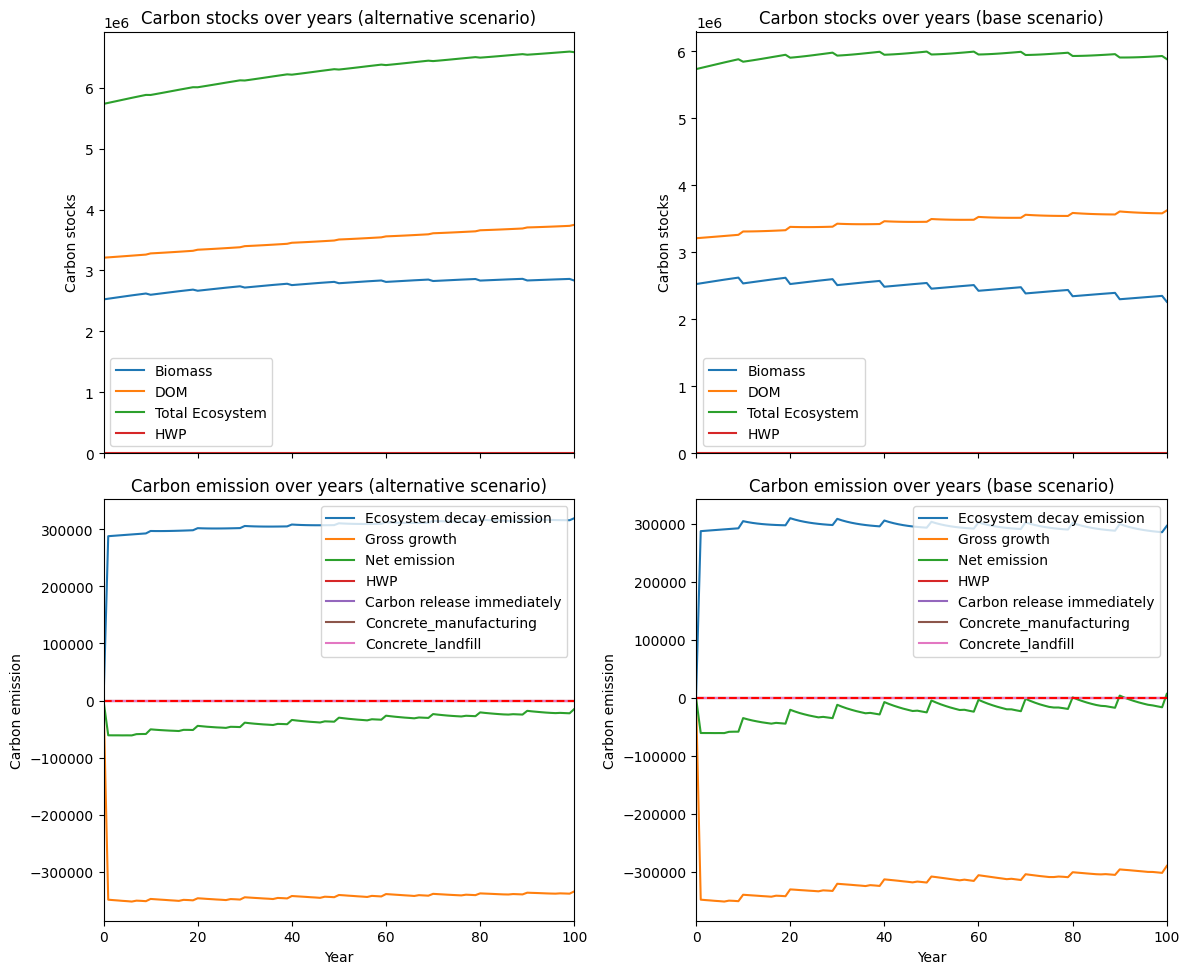

---------------------------------------------------------------------------------------
Net emission difference -1361359.105445188
Net emission base scenario -2265054.5554323117
Net emission alternative scenario -3626413.6608775
dollar_per_ton is:  7.345600407711547
Comparison of Old Growth Areas (Alternative - Base)
           0           10   Difference
Cedar    0.0   371.035224   371.035224
Aspen    0.0   100.571841   100.571841
Spruce   0.0  1930.365123  1930.365123
Hem      0.0   411.739126   411.739126
Birch    0.0    14.026344    14.026344
Bal      0.0   164.747784   164.747784
DougFir  0.0   598.562828   598.562828
Pine     0.0     0.000000     0.000000

Overall, the old growth area has **increased** by 3591.05 hectares in the alternative scenario compared to the base scenario.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
-----------

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


apply action error 1 ('tsa17', '1', '265', '304', '265', '1') harvest 1 280 -1.9342626808830675e-11
apply action error 1 ('tsa17', '1', '357', '500', '357', '1') harvest 4 154 -3.4991332960322103e-10
apply action error 1 ('tsa17', '1', '379', '204', '379', '2') harvest 5 99 -2.701560468426075e-09
apply action error 1 ('tsa17', '1', '265', '304', '265', '1') harvest 6 274 -2.369248488565078e-09
apply action error 1 ('tsa17', '1', '347', '702', '347', '1') harvest 6 314 -6.298364501473831e-10
apply action error 1 ('tsa17', '1', '347', '702', '347', '1') harvest 6 371 -2.43490311946927e-10
apply action error 1 ('tsa17', '1', '387', '100', '387', '1') harvest 7 234 -3.6476526232840344e-09
apply action error 1 ('tsa17', '1', '306', '100', '306', '1') harvest 8 361 -3.035417498679556e-09
apply action error 1 ('tsa17', '1', '306', '100', '306', '1') harvest 9 204 -1.7497434464440755e-09
apply action error 1 ('tsa17', '1', '357', '500', '357', '1') harvest 9 174 -9.157994133357022e-10


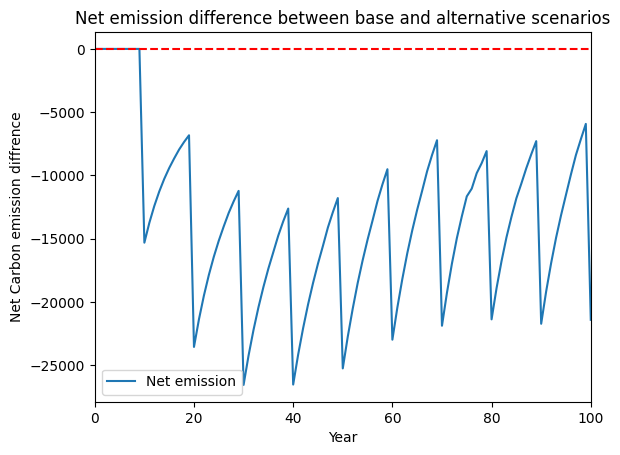

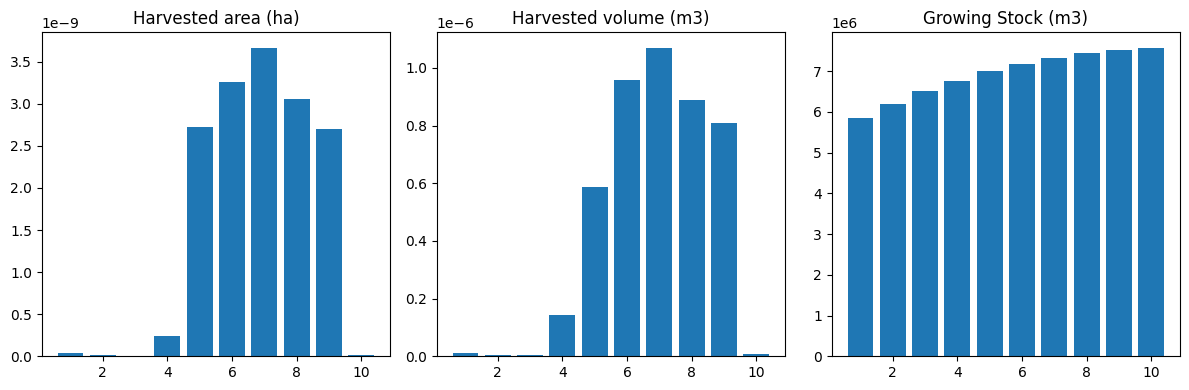

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_highest carbon stock_scheduling.pdf


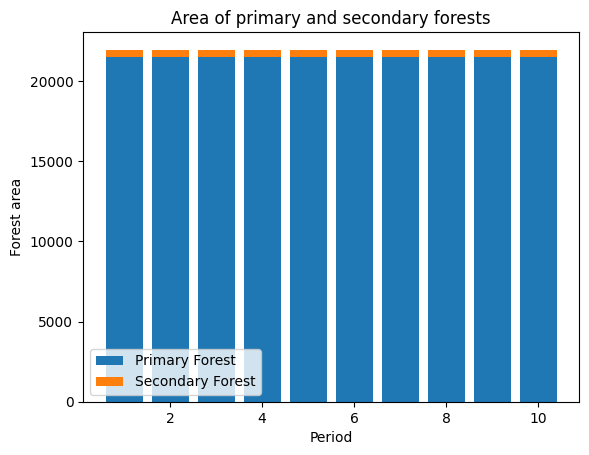

------------------------------------------------
The scocial indicator (the number of job creation) is:  0
The economic indicator (the provincial government revenues) is:  0
------------------------------------------------
Saved cbm_output_1 and cbm_output_2 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_highest carbon stock_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  2289.652623  2006.076065
Aspen      42.290489   519.192325   476.901835
Spruce   4471.720232  7098.592523  2626.872291
Hem      1246.520025  1621.166502   374.646477
Birch       3.090902    40.119295    37.028393
Bal      3699.410838  5331.685081  1632.274244
DougFir   504.920628  1597.575721  1092.655093
Pine      156.364968   204.552976    48.188007

Old growth has **increased** by 8294.64 hectares from time period 0 to time per

/media/data/home/sghotb/.virtualenvs/foo/lib/python3.10/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


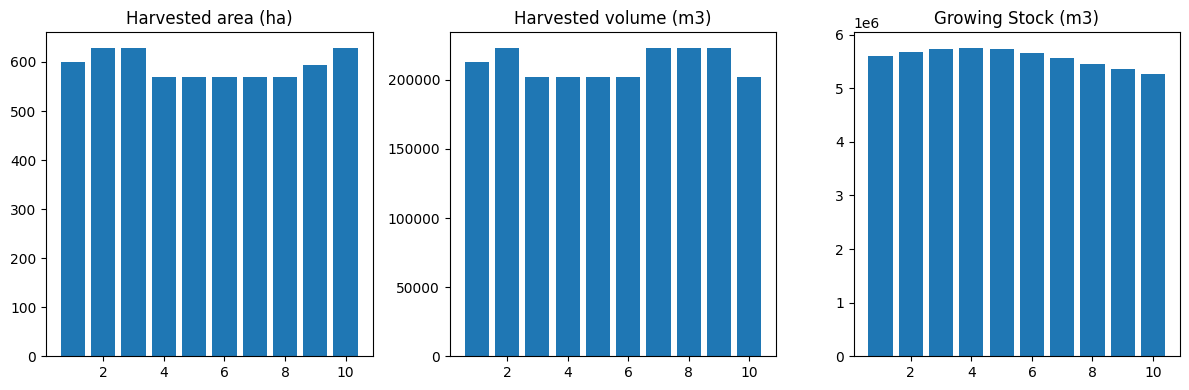

Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_scheduling.pdf


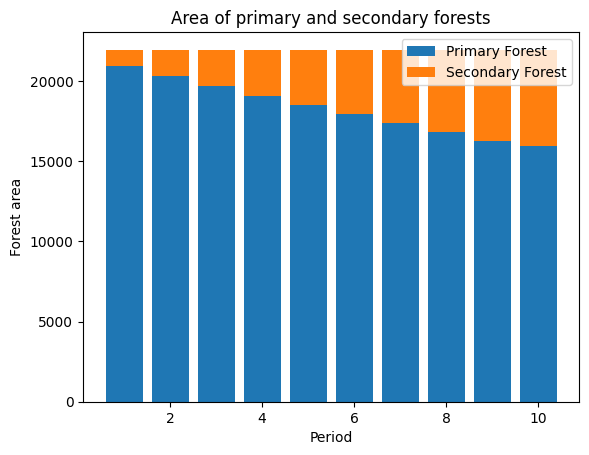

------------------------------------------------
The scocial indicator (the number of job creation) is:  2235
The economic indicator (the provincial government revenues) is:  76247
------------------------------------------------
Saved cbm_output_3 and cbm_output_4 as pickle files.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_business as usual_age_distribution.pdf

Old Growth Data (in hectares). 
Negative value indicates loss of old growth and positive value indicates gain of old growth.
                   0           10   Difference
Cedar     283.576558  1345.936035  1062.359477
Aspen      42.290489   199.632790   157.342301
Spruce   4471.720232  4804.661029   332.940797
Hem      1246.520025  1178.972393   -67.547633
Birch       3.090902    26.092950    23.002049
Bal      3699.410838  5166.937298  1467.526460
DougFir   504.920628   881.080832   376.160204
Pine      156.364968   204.552976    48.188007

Old growth has **increased** by 3399.97 hectares from time period 0 to time

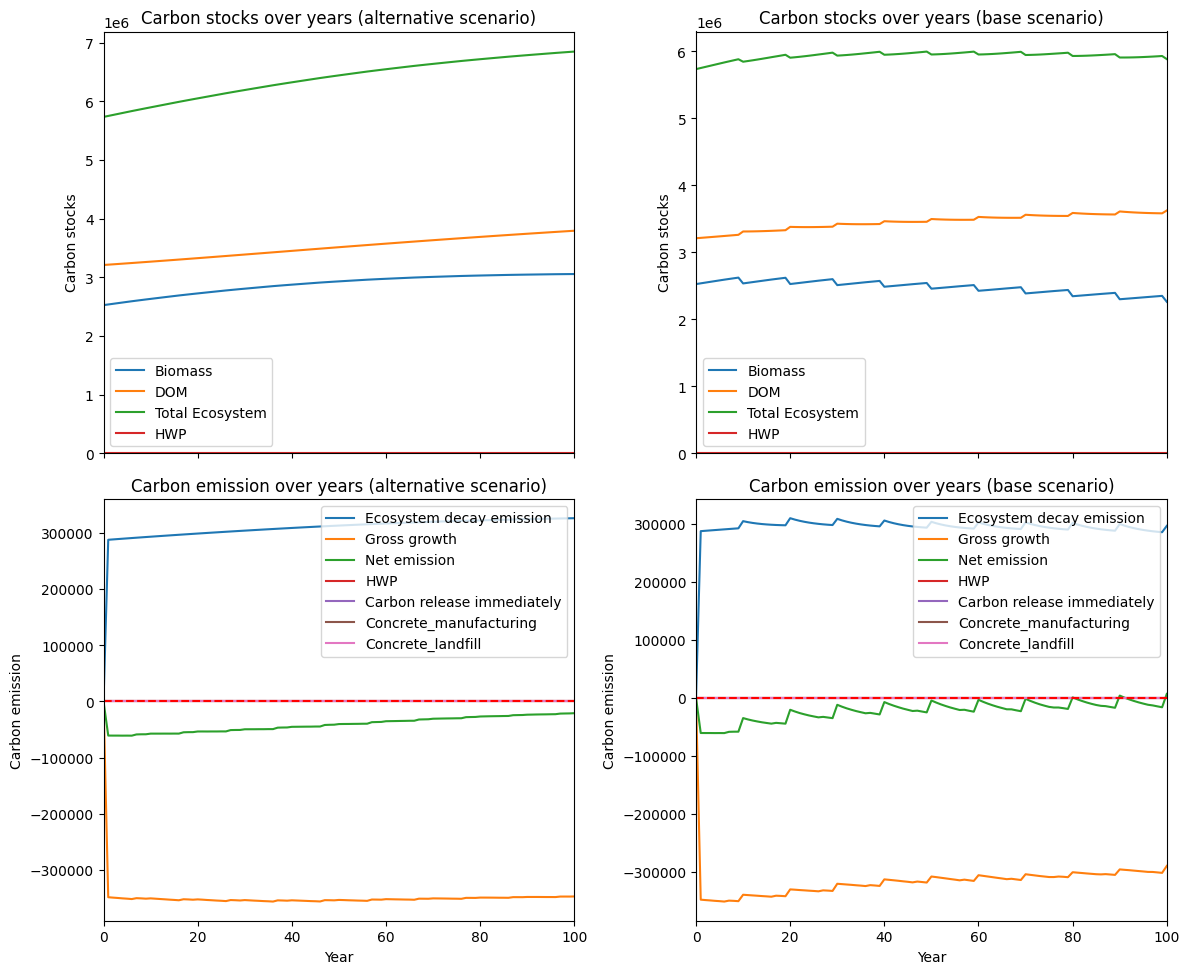

---------------------------------------------------------------------------------------
Net emission difference -1819454.6412956035
Net emission base scenario -2265054.5554323117
Net emission alternative scenario -4084509.1967279157
dollar_per_ton is:  5.496152403601095
Comparison of Old Growth Areas (Alternative - Base)
           0           10   Difference
Cedar    0.0   943.716588   943.716588
Aspen    0.0   319.559535   319.559535
Spruce   0.0  2293.931494  2293.931494
Hem      0.0   442.194109   442.194109
Birch    0.0    14.026344    14.026344
Bal      0.0   164.747784   164.747784
DougFir  0.0   716.494889   716.494889
Pine     0.0     0.000000     0.000000

Overall, the old growth area has **increased** by 4894.67 hectares in the alternative scenario compared to the base scenario.
Plot saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_age_difference.pdf
Pie Charts for Time Periods 0 and 10 saved to ./outputs/fig/ecotrust/ecotrust_max_hv_kpi_species_difference_pie.pdf
-------

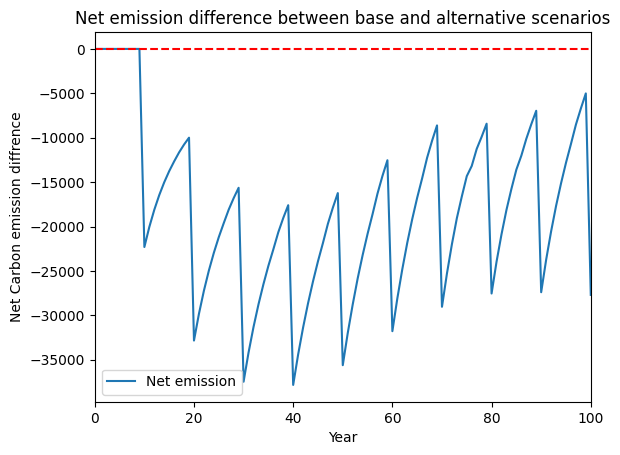

In [25]:
Start = time.time()

epsilon, cs_max = epsilon_computer(fm, clt_percentage, hwp_pool_effect_value, displacement_effect, release_immediately_value, n=10, solver=ws3.opt.SOLVER_PULP)
scenario_names = scenario_options.get(case_study, [])
for scenario_name in scenario_names:
    print(f"Running for {case_study}_{obj_mode}_{scenario_name}...")
    results_scenarios(fm, 
                      clt_percentage, 
                      credibility, 
                      budget_input, 
                      n_steps, 
                      max_harvest, 
                      scenario_name, 
                      displacement_effect, 
                      hwp_pool_effect_value, 
                      release_immediately_value, 
                      case_study, 
                      obj_mode, 
                      epsilon,
                      cs_max,
                      pickle_output_base=False, 
                      pickle_output_alter=False)
print('It took', round((time.time() - Start) / 60, 1), "minutes to run all scenarios.")

6788534.263521082
[183758.96516008934, 192600.4524415896, 201085.15347613266, 209039.8032183259]
[5657810.600316747, 5940491.516082216, 6223172.432460008, 6505853.347647391]


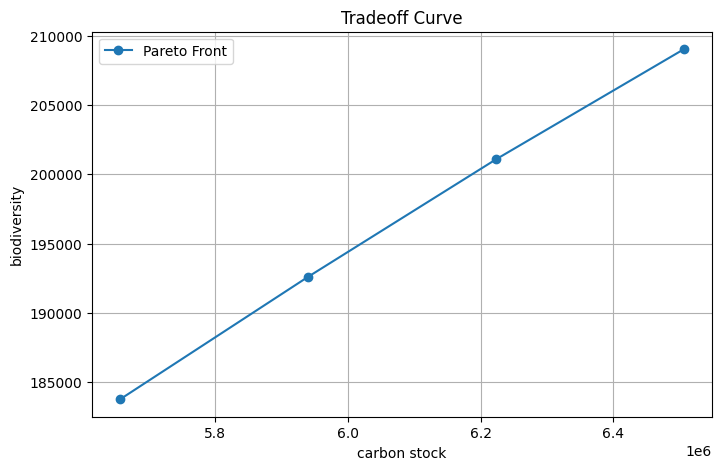

In [26]:
tradeoff_biodiversity_cs(fm, clt_percentage, hwp_pool_effect_value, displacement_effect, release_immediately_value, n=4, solver=ws3.opt.SOLVER_PULP)

[2.0881443021890847e-07, 754328.1782719688, 1437373.4773998358, 2024732.0489031207, 2548669.0131410426]
[6788534.263521202, 6505853.34745591, 6223172.431875134, 5940491.516308137, 5657810.600396672]


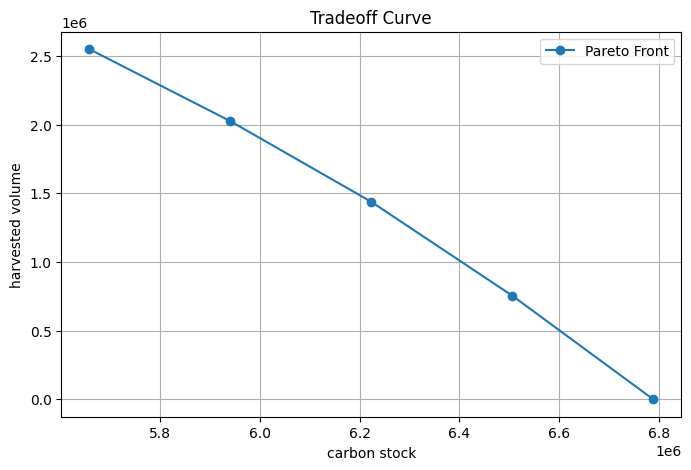

In [27]:
epsilon, cs_max = epsilon_computer(fm, clt_percentage, hwp_pool_effect_value, displacement_effect, release_immediately_value, n=4, solver=ws3.opt.SOLVER_PULP)
tradeoff_hv_cs(fm, clt_percentage, hwp_pool_effect_value, displacement_effect, release_immediately_value, epsilon, cs_max, n=4, solver=ws3.opt.SOLVER_PULP)

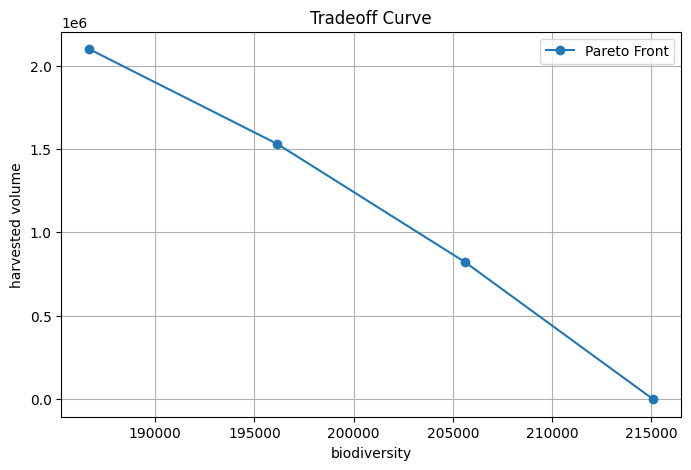

In [28]:
tradeoff_hv_biodiversity(fm, clt_percentage, hwp_pool_effect_value, displacement_effect, release_immediately_value, n=4, solver=ws3.opt.SOLVER_PULP)